In [1]:
using ConvDiffMIPDECO
using PyPlot
using jInv.Mesh
using jInv.ForwardShare
using jInv.InverseSolve
using jInvVis
using jInv.LinearSolvers
using MAT

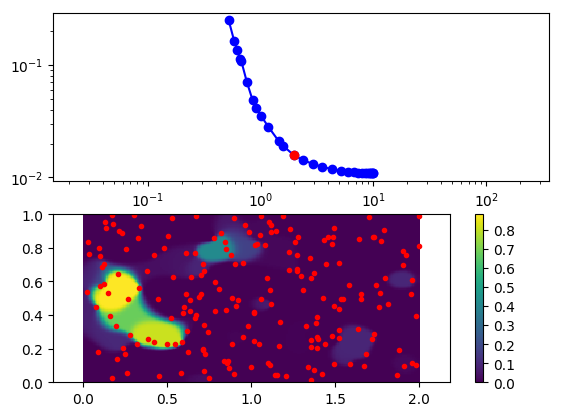

0.0032903445623126675

In [2]:
# read results from l-curve
dataset    = "Peaks2D"
reg        = "wTVReg"
m          = [256 128]
noiseLevel = 0.1

data = matread("$(dataset).mat")
domain = data["domain"]
v      = data["v"]
sig    = data["sig"]  
dtrue  = data["dtrue"]
rec    = data["rec"];

M = getRegularMesh(domain,m)

resFile = "results/$(dataset)-$(reg)-noise-$(noiseLevel)-$(m[1])x$(m[2]).mat"
res = matread(resFile)
dobs = res["dobs"]

idx = 13;
subplot(2,1,1)
loglog(res["Reg"],res["Mis"],"-ob")
loglog(res["Reg"][idx],res["Mis"][idx],"-or")
axis("equal")
subplot(2,1,2);
src0 = res["Sources"][:,idx]
alpha = res["alphas"][idx]
viewImage2D(src0,M)
plot(rec[:,1],rec[:,2],".r")
colorbar()
axis("equal")
res["alphas"][idx]

In [3]:
# build inverse problem
x1,x2 = getNodalAxes(M)
P = interpmat(x1,x2, rec);
pFor = getConvDiffFEMParam(M,v=v,sig=sig,P=P,Ainv=getMUMPSsolver());

## configure misfit
Wt         = ones(size(dobs))      
sigback    = 0.0
pMis       = getMisfitParam(pFor,Wt,dobs,SSDFun) 
	
## Configure regularization
mref       = zeros(M.nc)           
reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  
# reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  

## Configure optimization
maxIter    = 10
minUpdate  = 1e-3
HesPrec    = getSSORRegularizationPreconditioner(1.0,1e-15,50)
cgit       = 5 
pcgTol     = 1e-1
modFun     = identityMod
boundsLow  = 0*ones(M.nc)
boundsHigh = 1*ones(M.nc)
maxStep	   = 0.1*maximum(boundsHigh)

## store the configuration 
pInv       = getInverseParam(M,modFun,reg,alpha,mref,
                             boundsLow,boundsHigh,maxStep=maxStep,
                            pcgMaxIter=cgit,pcgTol=pcgTol,minUpdate=minUpdate,maxIter=maxIter,
                            HesPrec=HesPrec);


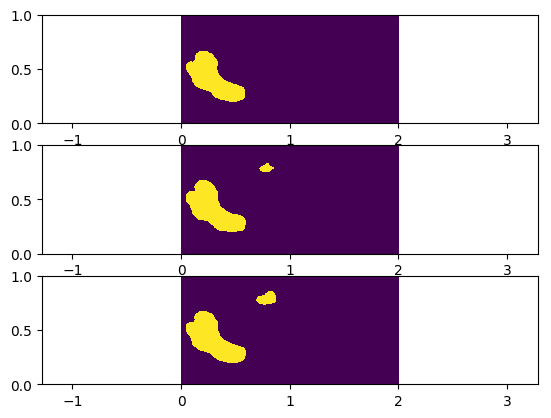

In [4]:
roundings = (s->naiveRounding(s),s->massPreservingRounding(s), s->objGapRedRounding(s,pMis,pInv))
neighborhoods = (s->trues(size(s)), s->dilation(s,pInv.MInv,1), s->dilation(s,pInv.MInv,2))

for k=1:length(roundings)
    subplot(length(roundings),1,k)
    src0 = roundings[k](res["Sources"][:,idx])
    viewImage2D(src0,M)
    axis("equal")
end


Trust region on entire space: MisFit, Regularizer, Total 0.01503614510828095 , 0.015399036441038027	, 0.030435181549318978
Time to compute Data term, Regularizer, and MIP: 0.6846766830000001, 1.178462892, 0.16104697799999998 

Trust region on entire space: MisFit, Regularizer, Total 0.038753933992635235 , 0.010883914627298484	, 0.04963784861993372
Time to compute Data term, Regularizer, and MIP: 0.9827646969999999, 1.95014144, 0.090502673 

Trust region on entire space: MisFit, Regularizer, Total 0.04247151662555452 , 0.009621671951531185	, 0.052093188577085704
Time to compute Data term, Regularizer, and MIP: 0.797113879, 1.4626918339999997, 0.09511676100000002 

Trust region on entire space: MisFit, Regularizer, Total 0.01504296405281827 , 0.01600053244615731	, 0.03104349649897558
Time to compute Data term, Regularizer, and MIP: 0.8872595939999999, 1.6479167919999995, 0.11189716599999998 

Trust region on entire space: MisFit, Regularizer, Total 0.01713944040726443 , 0.010751213312836

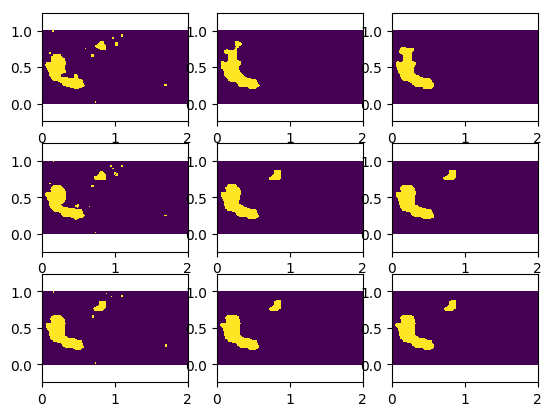

Trust region on entire space: MisFit, Regularizer, Total 0.017035815749912607 , 0.010760034194832496	, 0.027795849944745103
Time to compute Data term, Regularizer, and MIP: 0.8608293090000001, 1.58333367, 0.06809610600000002 



In [5]:
nrow = length(roundings)
ncol = length(neighborhoods)
pInv.maxIter=50

results = zeros(m[1],m[2],length(roundings),length(neighborhoods))
init = zeros(m[1],m[2],length(roundings),length(neighborhoods))
His = zeros(pInv.maxIter,3,length(roundings),length(neighborhoods))
times = zeros(length(roundings),length(neighborhoods))
for k1=1:length(roundings)
    for k2=1:length(neighborhoods)
        src0 = roundings[k1](res["Sources"][:,idx])
        init[:,:,k1,k2] = src0
        tic()
        mcTR,DcTR,flagTR,his = mipdecoHeuristic(src0,pInv,pMis,getNeighborhood=neighborhoods[k2],out=0)
        results[:,:,k1,k2] = mcTR
        His[:,:,k1,k2] = his;
        times[k1,k2] = toq()
        
        subplot(nrow,ncol,k2+(k1-1)*ncol)
        viewImage2D(mcTR,M)
        axis("equal")
    end
end



In [6]:
res["MIPDECO"]=results
res["MIPDECOinit"]=init
res["His"] = His
res["times"] = times
# resFirele
matwrite(resFile,res)

In [ ]:
times

In [ ]:
his = His[:,:,1,1];
